In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install datasets wordcloud 
!{sys.executable} pip install --user -U nltk
!pip install scipy gensim==3.8.3

/Users/olohireme/opt/anaconda3/bin/python: can't open file 'pip': [Errno 2] No such file or directory


In [2]:
from datasets import load_dataset
from wordcloud import WordCloud, STOPWORDS
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import json
from pandas.io.json import json_normalize
dataset = load_dataset("climate_fever")

Using custom data configuration default
Reusing dataset climate_fever (/Users/olohireme/.cache/huggingface/datasets/climate_fever/default/1.0.1/3b846b20d7a37bc0019b0f0dcbde5bf2d0f94f6874f7e4c398c579f332c4262c)


In [3]:
print(dataset)

DatasetDict({
    test: Dataset({
        features: ['claim_id', 'claim', 'claim_label', 'evidences'],
        num_rows: 1535
    })
})


In [4]:
print(dataset['test'][0])

{'claim': 'Global warming is driving polar bears toward extinction', 'claim_id': '0', 'claim_label': 0, 'evidences': [{'article': 'Extinction risk from global warming', 'entropy': 0.6931471824645996, 'evidence': '"Recent Research Shows Human Activity Driving Earth Towards Global Extinction Event".', 'evidence_id': 'Extinction risk from global warming:170', 'evidence_label': 2, 'votes': ['SUPPORTS', 'NOT_ENOUGH_INFO', None, None, None]}, {'article': 'Global warming', 'entropy': 0.0, 'evidence': 'Environmental impacts include the extinction or relocation of many species as their ecosystems change, most immediately the environments of coral reefs, mountains, and the Arctic.', 'evidence_id': 'Global warming:14', 'evidence_label': 0, 'votes': ['SUPPORTS', 'SUPPORTS', None, None, None]}, {'article': 'Global warming', 'entropy': 0.6931471824645996, 'evidence': 'Rising temperatures push bees to their physiological limits, and could cause the extinction of bee populations.', 'evidence_id': 'Glo

In [5]:
print(len(dataset['test']))
df_1 = dataset['test']
#result = pd.json_normalize(df_1, 'evidences', ['evidence_id', 'evidence_label', 'article', 'evidence','entropy','votes'], errors='ignore',record_prefix='Prefix.')
result = pd.json_normalize(df_1, 'evidences', ['claim', 'claim_id','claim_label'], errors='ignore',record_prefix='Evidence.')
#MAKE df like the csv to df here - https://www.kaggle.com/kerneler/starter-climate-fever-dataset-6360dcf6-9
result


1535


,Evidence.article,Evidence.entropy,Evidence.evidence,Evidence.evidence_id,Evidence.evidence_label,Evidence.votes,claim,claim_id,claim_label
0,Extinction risk from global warming,0.693147,"""Recent Research Shows Human Activity Driving ...",Extinction risk from global warming:170,2,"[SUPPORTS, NOT_ENOUGH_INFO, None, None, None]",Global warming is driving polar bears toward e...,0,0
1,Global warming,0.000000,Environmental impacts include the extinction o...,Global warming:14,0,"[SUPPORTS, SUPPORTS, None, None, None]",Global warming is driving polar bears toward e...,0,0
2,Global warming,0.693147,Rising temperatures push bees to their physiol...,Global warming:178,2,"[SUPPORTS, NOT_ENOUGH_INFO, None, None, None]",Global warming is driving polar bears toward e...,0,0
3,Habitat destruction,0.000000,"Rising global temperatures, caused by the gree...",Habitat destruction:61,0,"[SUPPORTS, SUPPORTS, None, None, None]",Global warming is driving polar bears toward e...,0,0
4,Polar bear,0.693147,"""Bear hunting caught in global warming debate"".",Polar bear:1328,2,"[SUPPORTS, NOT_ENOUGH_INFO, None, None, None]",Global warming is driving polar bears toward e...,0,0
...,...,...,...,...,...,...,...,...,...
7670,Bushfires in Australia,0.000000,Australia's climate has warmed by more than on...,Bushfires in Australia:126,0,"[None, SUPPORTS, SUPPORTS, None, None]","Over the last decade, heatwaves are five times...",3134,0
7671,Effects of global warming,0.693147,"In the last 30–40 years, heat waves with high ...",Effects of global warming:86,2,"[None, SUPPORTS, NOT_ENOUGH_INFO, None, None]","Over the last decade, heatwaves are five times...",3134,0
7672,Global warming,0.693147,Many regions have probably already seen increa...,Global warming:155,2,"[None, SUPPORTS, NOT_ENOUGH_INFO, None, None]","Over the last decade, heatwaves are five times...",3134,0
7673,Global warming,0.693147,"Since the 1950s, droughts and heat waves have ...",Global warming:156,2,"[None, SUPPORTS, NOT_ENOUGH_INFO, None, None]","Over the last decade, heatwaves are five times...",3134,0


In [6]:
#data = pd.read_json(dataset['test'])
#data.head()
df = pd.DataFrame(dataset['test'])


In [7]:
df.head()

,claim,claim_id,claim_label,evidences
0,Global warming is driving polar bears toward e...,0,0,[{'article': 'Extinction risk from global warm...
1,The sun has gone into ‘lockdown’ which could c...,5,0,"[{'article': 'Famine', 'entropy': 0.0, 'eviden..."
2,The polar bear population has been growing.,6,1,"[{'article': 'Polar bear', 'entropy': 0.693147..."
3,Ironic' study finds more CO2 has slightly cool...,9,1,"[{'article': 'Atmosphere of Mars', 'entropy': ..."
4,Human additions of CO2 are in the margin of er...,10,1,[{'article': 'Carbon dioxide in Earth's atmosp...


<AxesSubplot:xlabel='claim_label', ylabel='Count'>

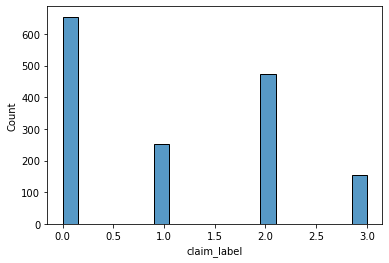

In [8]:
#histogram of claim by claim label
sns.histplot(data = df, x ='claim_label', bins = 20)


Previous Transformations

In [9]:
def to_Dict(arr):
    keys = np.arange(start=0, stop=5, step=1)
    dictionary = dict(zip(keys, arr))
    return dictionary

In [10]:
df['evidences'] = df['evidences'].apply(lambda x: to_Dict(x))

In [11]:
df['evidences'].head()

0    {0: {'article': 'Extinction risk from global w...
1    {0: {'article': 'Famine', 'entropy': 0.0, 'evi...
2    {0: {'article': 'Polar bear', 'entropy': 0.693...
3    {0: {'article': 'Atmosphere of Mars', 'entropy...
4    {0: {'article': 'Carbon dioxide in Earth's atm...
Name: evidences, dtype: object

In [12]:
v = pd.DataFrame(df['evidences'].to_dict()).stack()

v = (pd.DataFrame(v.tolist(), index=v.index)
   .unstack(0)
   .stack())
new_v = v.reset_index(drop=True)

In [13]:
new_v[0:10]

,article,entropy,evidence,evidence_id,evidence_label,votes
0,Extinction risk from global warming,0.693147,"""Recent Research Shows Human Activity Driving ...",Extinction risk from global warming:170,2,"[SUPPORTS, NOT_ENOUGH_INFO, None, None, None]"
1,Global warming,0.000000,Environmental impacts include the extinction o...,Global warming:14,0,"[SUPPORTS, SUPPORTS, None, None, None]"
2,Global warming,0.693147,Rising temperatures push bees to their physiol...,Global warming:178,2,"[SUPPORTS, NOT_ENOUGH_INFO, None, None, None]"
3,Habitat destruction,0.000000,"Rising global temperatures, caused by the gree...",Habitat destruction:61,0,"[SUPPORTS, SUPPORTS, None, None, None]"
4,Polar bear,0.693147,"""Bear hunting caught in global warming debate"".",Polar bear:1328,2,"[SUPPORTS, NOT_ENOUGH_INFO, None, None, None]"
5,Famine,0.000000,The current consensus of the scientific commun...,Famine:386,0,"[SUPPORTS, SUPPORTS, None, None, None]"
6,Weather,0.000000,The Little Ice Age caused crop failures and fa...,Weather:67,0,"[SUPPORTS, SUPPORTS, None, None, None]"
7,Winter,0.000000,"The persistently cold, wet weather caused grea...",Winter:114,0,"[SUPPORTS, SUPPORTS, None, None, None]"
8,Winter,0.693147,The manifestation of the meteorological winter...,Winter:20,2,"[REFUTES, NOT_ENOUGH_INFO, None, None, None]"
9,Winter,0.693147,"In many regions, winter is associated with sno...",Winter:5,2,"[REFUTES, NOT_ENOUGH_INFO, None, None, None]"


End of Previous Transformations

<AxesSubplot:xlabel='evidence_label', ylabel='Count'>

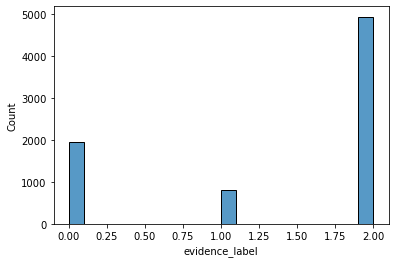

In [14]:
#histogram of evidence by label, evidence by entropy
sns.histplot(data = new_v, x ='evidence_label', bins = 20)


<AxesSubplot:xlabel='entropy', ylabel='Count'>

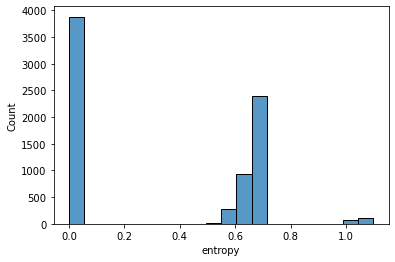

In [15]:
sns.histplot(data = new_v, x ='entropy', bins = 20)

In [16]:
#create sentences vector
sentences = np.concatenate((df['claim'].to_numpy(),new_v['article'].to_numpy(),new_v['evidence'].to_numpy(),new_v['evidence_id'].to_numpy()))
sentences

array(['Global warming is driving polar bears toward extinction',
       'The sun has gone into ‘lockdown’ which could cause freezing weather, earthquakes and famine, say scientists',
       'The polar bear population has been growing.', ...,
       'Global warming:155', 'Global warming:156', 'Heat wave:151'],
      dtype=object)

In [17]:
print(len(sentences))

24560


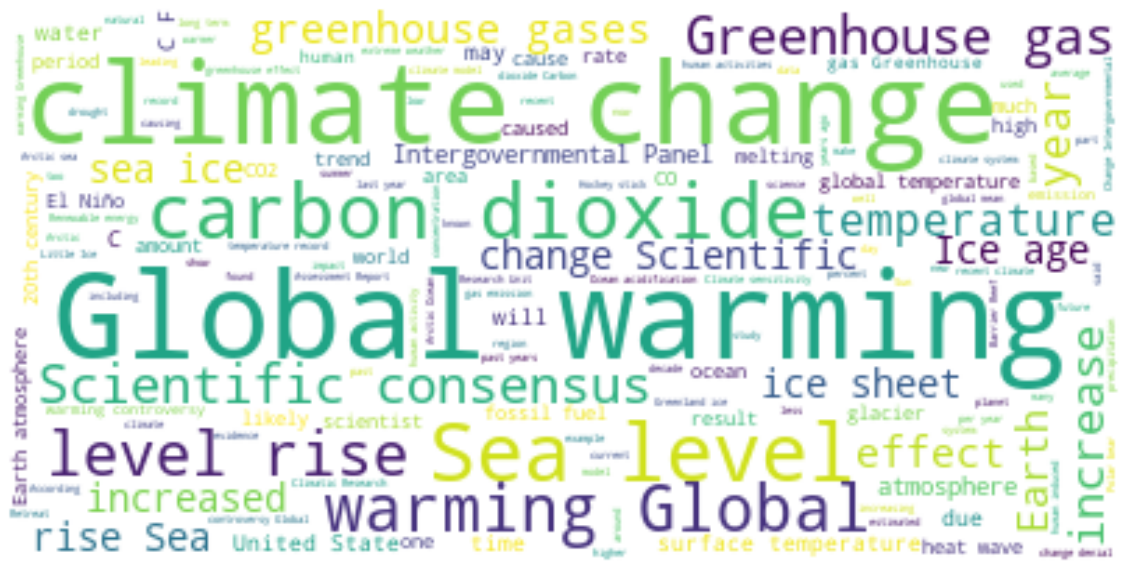

In [18]:
#visualization
#word cloud
stopwords = set(STOPWORDS) 
words = " ".join(word for word in sentences)
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(words)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=[20,15])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [19]:
#remove article and evidence id features
#scatter text plot? - https://github.com/JasonKessler/scattertext#tutorial
#pie chart of claims by claim_label

In [20]:
#run only once
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/olohireme/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
#preprocessing
#tokenizing
climateVec = [nltk.word_tokenize(word) for word in sentences]
climateVec

[['Global',
  'warming',
  'is',
  'driving',
  'polar',
  'bears',
  'toward',
  'extinction'],
 ['The',
  'sun',
  'has',
  'gone',
  'into',
  '‘',
  'lockdown',
  '’',
  'which',
  'could',
  'cause',
  'freezing',
  'weather',
  ',',
  'earthquakes',
  'and',
  'famine',
  ',',
  'say',
  'scientists'],
 ['The', 'polar', 'bear', 'population', 'has', 'been', 'growing', '.'],
 ['Ironic',
  "'",
  'study',
  'finds',
  'more',
  'CO2',
  'has',
  'slightly',
  'cooled',
  'the',
  'planet'],
 ['Human',
  'additions',
  'of',
  'CO2',
  'are',
  'in',
  'the',
  'margin',
  'of',
  'error',
  'of',
  'current',
  'measurements',
  'and',
  'the',
  'gradual',
  'increase',
  'in',
  'CO2',
  'is',
  'mainly',
  'from',
  'oceans',
  'degassing',
  'as',
  'the',
  'planet',
  'slowly',
  'emerges',
  'from',
  'the',
  'last',
  'ice',
  'age',
  '.'],
 ['They',
  'tell',
  'us',
  'that',
  'we',
  'are',
  'the',
  'primary',
  'forces',
  'controlling',
  'earth',
  'temperatures',

In [22]:
#stop word removal
#stemming
#unique words
#show word cloud again
#bag of words
#split into train test with sklearn
#genism

In [23]:
model = Word2Vec(climateVec, min_count=1, size=32)
model.most_similar('global')

<ipython-input-23-07ea660de648>:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model.most_similar('global')


[('trend', 0.8974586725234985),
 ('long-term', 0.893576443195343),
 ('slight', 0.8735213279724121),
 ('cause', 0.8716675043106079),
 ('pace', 0.8630733489990234),
 ('resultant', 0.8626089692115784),
 ('evident', 0.8585765361785889),
 ('assertions', 0.8458077907562256),
 ('Surface', 0.8335598707199097),
 ('further', 0.8320874571800232)]

Similar words seem wrong. Let's look at the effect after preprocessing

In [24]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [25]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [32]:
filtered_sent = [[word for word in w_vector if word.lower() not in stop_words] for w_vector in climateVec]

In [33]:
filtered_sent

[['Global', 'warming', 'driving', 'polar', 'bears', 'toward', 'extinction'],
 ['sun',
  'gone',
  '‘',
  'lockdown',
  '’',
  'could',
  'cause',
  'freezing',
  'weather',
  ',',
  'earthquakes',
  'famine',
  ',',
  'say',
  'scientists'],
 ['polar', 'bear', 'population', 'growing', '.'],
 ['Ironic', "'", 'study', 'finds', 'CO2', 'slightly', 'cooled', 'planet'],
 ['Human',
  'additions',
  'CO2',
  'margin',
  'error',
  'current',
  'measurements',
  'gradual',
  'increase',
  'CO2',
  'mainly',
  'oceans',
  'degassing',
  'planet',
  'slowly',
  'emerges',
  'last',
  'ice',
  'age',
  '.'],
 ['tell',
  'us',
  'primary',
  'forces',
  'controlling',
  'earth',
  'temperatures',
  'burning',
  'fossil',
  'fuels',
  'releasing',
  'carbon',
  'dioxide',
  '.'],
 ['Great',
  'Barrier',
  'Reef',
  'experiencing',
  'widespread',
  'bleaching',
  'ever',
  'recorded'],
 ['’', 'pollutant', 'threatens', 'human', 'civilization', '.'],
 ['CO2',
  'terrible',
  'planet',
  ',',
  'instal